In [204]:
# Python 3 notebook for neural network

import numpy as np
import math
import statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import importlib
import sys
import pickle
import torch
from torch.autograd import Variable
import torch.nn as nn
from random import shuffle

# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
we = importlib.import_module("word_embeddings")
import re

In [205]:
""" Global Parameters """
# Load some data
wordEmbedDict = we.getWordEmbeddingDict() # Load the dictionary

# Labels
top_20 = sorted(['AskReddit', 'leagueoflegends', 'nba', 'funny', 'pics', 'nfl', 'pcmasterrace', \
          'videos', 'news', 'todayilearned', 'DestinyTheGame', 'worldnews', 'soccer', \
          'DotA2', 'AdviceAnimals', 'WTF', 'GlobalOffensive', 'hockey', 'movies', 'SquaredCircle'])

# Indices of our desired data
TRUE_LABEL = 8 # Index of the true label, hard coded
BODY_INDEX = 17 # Index of the reddit comment, hard coded

# Neural Network Parameters
NUM_SUBREDDITS = len(top_20)
NUM_FEATURES = 300 # length returned from embedding
NUM_EXAMPLES = 9999 # Arbitrary, choose however many we want to grab from the dataset
NUM_EPOCHS = 500 
NUM_HIDDEN_NEURONS = 20
NUM_LAYERS = 15
LEARNING_RATE = 0.001

SUBREDDIT = "leagueoflegends" # used for debugging,delete later
unparsed = "./data/condensed_dataset_SMALL.pkl" # will change this so we can just call the whole pkl set

# Encoder
encoder = LabelEncoder()
encoder.fit(top_20) # Encodes the NUM_SUBREDDITS subreddits

# Seed
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
""" """

' '

In [206]:
'''Helper Functions'''

# Normalization of dataset

# Get mean of a column feature
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean

def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var

def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)
        
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
    return set

# @param dir: string, directory of pickle data
# @return dataset: unpickled dataset
def loadPickleData(dir):
    with open(dir, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

# Returns [X, Y] with m examples
def loadData(pickleDir, m):
    pickle = loadPickleData(pickleDir)
    return vectorizeDataSet(pickle, m)

def stripNonAlpha(word):
    word = re.sub(r'\W+', '', word)
    return word

def vectorizeWord(word):
    word = stripNonAlpha(word)
    keyset = wordEmbedDict.keys() # words in the dictionary
    zeroVec = np.zeros((1, NUM_FEATURES))
    vWord = pd.DataFrame(zeroVec)
    
    if word in keyset:
        vWord = pd.DataFrame(wordEmbedDict[word]).transpose()
    return vWord # returns zero vector if the word is not in the dictionary

def vectorizeComment(body):
    vComment = np.zeros((1, NUM_FEATURES))
    vComment = pd.DataFrame(vComment)
    words = body.split()
#     print(vComment)
    
    numWords = 0
    for word in words:
        vWord = vectorizeWord(word)
        numWords += 1
        vComment = vComment + vWord
    vComNP = vComment.values
    vComScaled = vComNP * (1/float(numWords))
    vComScaled = pd.DataFrame(vComScaled)
    return vComScaled

# Encodes a subreddit string into an unrolled one-hot pandas vector
def oneHotEncode(subreddit):
    #   https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
    encoded_Y = encoder.transform([subreddit])[0] # get the integer category
    
    oneHot = [0 for _ in range(NUM_SUBREDDITS)]
    oneHot[encoded_Y] = 1
    pandasOneHot = pd.DataFrame(oneHot)
    
    return pandasOneHot.transpose()
    
    
#TODO: check if seed is bad??
#TODO: limit number of features 
def vectorizeDataSet(data, m):
    data = pd.DataFrame(data)
    data = data.sample(frac=1, random_state=seed).reset_index(drop=True) # Shuffles data
    
    comments = data.pop(BODY_INDEX)
    true_labels = data.pop(TRUE_LABEL)
    
    unrollComment = comments[0]
    X = vectorizeComment(unrollComment)
    firstSubreddit = true_labels[0]
    Y = oneHotEncode(firstSubreddit)

    # For each example in old data set, get the actual comment and featurize it into X
    # Also get unrolled true label
    for i in range(1, m):
        comment = comments[i]
        example = vectorizeComment(comment)
        subreddit = true_labels[i]
        oneHot = oneHotEncode(subreddit)
        
        X = pd.concat([X, example])
        Y = pd.concat([Y, oneHot])
        
    X_scaled = preprocessing.StandardScaler().fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled)
    X_scaled_df.reset_index(drop=True, inplace=True)
    Y.reset_index(drop=True, inplace=True)
    concat = pd.concat([X_scaled_df, Y], axis=1)
    return concat

In [207]:
# Split dataset
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.9, validate_percent=.05, seed=seed):
    m = len(df.index)
    
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.loc[validate_end:]
    return train, validate, test

In [208]:
%%time
df = loadData(unparsed, NUM_EXAMPLES)
train, validate, test = train_validate_test_split(df)

train_labels = train.iloc[:, NUM_FEATURES:]
validate_labels = validate.iloc[:, NUM_FEATURES:]
test_labels = test.iloc[:, NUM_FEATURES:]

train = train.iloc[:, :NUM_FEATURES]
validate = validate.iloc[:, :NUM_FEATURES]
test = test.iloc[:, :NUM_FEATURES]

CPU times: user 6min 57s, sys: 922 ms, total: 6min 57s
Wall time: 6min 57s


In [80]:
%%time
# # Save the dataframe as a pickle file to be read later
# df.to_pickle("./data/pandas-pickle-small.pkl")

# check if potentially overwriting data with the same feature everytime
unpickled = pd.read_pickle("./data/pandas-pickle-small.pkl")
unpickled.tail()

,0,1,2,3,4,5,6,7,8,9,...,10,11,12,13,14,15,16,17,18,19
0,0.367342,1.308372,0.201091,-3.792920,1.512685,-1.171437,-69.51420,4.771135,0.642789,-8.226592,...,0,0,0,0,0,0,0,0,0,0
0,-2.128425,2.949559,-9.924261,-14.220757,2.549121,-0.092738,-258.15574,21.234065,1.738370,-24.388043,...,0,0,1,0,0,0,0,0,0,0
0,-4.771319,-1.761555,-3.291630,-19.368265,6.209984,-4.717876,-413.18892,38.096338,5.955578,-32.400210,...,0,0,0,0,0,0,0,0,0,1
0,-4.386540,0.150851,-1.026398,-5.580354,2.035692,-4.830088,-77.26690,4.216888,0.398812,-10.544630,...,0,0,0,0,0,0,0,0,0,0
0,-2.028093,4.679899,-2.142423,-3.440545,-1.290550,0.699776,-117.00810,7.079300,1.763391,-11.121207,...,1,0,0,0,0,0,0,0,0,0


In [209]:
%%time
# Check softmax output (final layer output)
# Check gradients inside the keras model built in function
# Neural network function
def build_nn(hidden_layer_sizes):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Dense(hidden_layer_sizes[0], input_dim=NUM_FEATURES, activation='relu'))

    # Conv1d Layer to fix high variance
#     model.add(layers.Conv1D(kernel_size = (10),strides=10,filters=2, input_shape=(hidden_layer_sizes[0],NUM_FEATURES),kernel_initializer= 'uniform',activation='relu'))
    
#      https://datascience.stackexchange.com/questions/19407/keras-built-in-multi-layer-shortcut
#     Hidden layers
    for size in hidden_layer_sizes[1:]:
        model.add(layers.Dense(size, activation='relu'))
        
    # Fixes somethings for some reason
#     model.add(layers.Flatten())
    
    # Output layer
    model.add(layers.Dense(NUM_SUBREDDITS, activation='softmax'))
    
    # Optimizer. Can change this to whatever we want
    optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'categorical_crossentropy'])
    return model

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21.7 µs


In [210]:
%%time
# Build the model
# Features might be an issue, pick different subreddits
# potentially try out CNN with matrix word embedding without combined word embedding
sizes_list = [NUM_HIDDEN_NEURONS for i in range(NUM_LAYERS)]
nn_model = build_nn(sizes_list)
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 20)                6020      
_________________________________________________________________
dense_187 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_188 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_189 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_190 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_191 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_192 (Dense)            (None, 20)                420       
__________

In [211]:
%%time
# Get neural network history
# Change batch size (inspect what happens with each ITERATION, not EPOCH)
# History is the progress of our neural network, will be used to plot cost functions
nn_history = nn_model.fit(train, train_labels, epochs=NUM_EPOCHS, verbose=1,
         validation_data=(validate, validate_labels))

Train on 8999 samples, validate on 499 samples
Epoch 1/500
8999/8999 [==============================] - 2s 232us/sample - loss: 2.8774 - acc: 0.0765 - categorical_crossentropy: 2.8774 - val_loss: 2.7412 - val_acc: 0.0701 - val_categorical_crossentropy: 2.7412
Epoch 2/500
8999/8999 [==============================] - 1s 135us/sample - loss: 2.6526 - acc: 0.1003 - categorical_crossentropy: 2.6526 - val_loss: 2.6473 - val_acc: 0.0862 - val_categorical_crossentropy: 2.6473
Epoch 3/500
8999/8999 [==============================] - 1s 136us/sample - loss: 2.5938 - acc: 0.1110 - categorical_crossentropy: 2.5938 - val_loss: 2.6238 - val_acc: 0.1022 - val_categorical_crossentropy: 2.6238
Epoch 4/500
8999/8999 [==============================] - 1s 138us/sample - loss: 2.5527 - acc: 0.1202 - categorical_crossentropy: 2.5527 - val_loss: 2.6213 - val_acc: 0.1022 - val_categorical_crossentropy: 2.6213
Epoch 5/500
8999/8999 [==============================] - 1s 138us/sample - loss: 2.5175 - acc: 0.1276

8999/8999 [==============================] - 1s 136us/sample - loss: 1.8509 - acc: 0.3403 - categorical_crossentropy: 1.8509 - val_loss: 2.5884 - val_acc: 0.1984 - val_categorical_crossentropy: 2.5884
Epoch 40/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.8463 - acc: 0.3433 - categorical_crossentropy: 1.8463 - val_loss: 2.6126 - val_acc: 0.1904 - val_categorical_crossentropy: 2.6126
Epoch 41/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.8348 - acc: 0.3499 - categorical_crossentropy: 1.8348 - val_loss: 2.6809 - val_acc: 0.1964 - val_categorical_crossentropy: 2.6809
Epoch 42/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.8297 - acc: 0.3493 - categorical_crossentropy: 1.8297 - val_loss: 2.6608 - val_acc: 0.2084 - val_categorical_crossentropy: 2.6608
Epoch 43/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.8310 - acc: 0.3514 - categorical_crossentropy: 1.8310 - val_loss: 2.6475 

8999/8999 [==============================] - 1s 135us/sample - loss: 1.6684 - acc: 0.3997 - categorical_crossentropy: 1.6684 - val_loss: 2.8651 - val_acc: 0.1924 - val_categorical_crossentropy: 2.8651
Epoch 78/500
8999/8999 [==============================] - 1s 137us/sample - loss: 1.6575 - acc: 0.4035 - categorical_crossentropy: 1.6575 - val_loss: 2.9142 - val_acc: 0.2004 - val_categorical_crossentropy: 2.9142
Epoch 79/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.6589 - acc: 0.4059 - categorical_crossentropy: 1.6589 - val_loss: 2.8386 - val_acc: 0.2184 - val_categorical_crossentropy: 2.8386
Epoch 80/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.6329 - acc: 0.4146 - categorical_crossentropy: 1.6329 - val_loss: 2.9566 - val_acc: 0.2024 - val_categorical_crossentropy: 2.9566
Epoch 81/500
8999/8999 [==============================] - 1s 138us/sample - loss: 1.6125 - acc: 0.4206 - categorical_crossentropy: 1.6125 - val_loss: 2.9539 

8999/8999 [==============================] - 1s 136us/sample - loss: 1.5170 - acc: 0.4609 - categorical_crossentropy: 1.5170 - val_loss: 3.2839 - val_acc: 0.1944 - val_categorical_crossentropy: 3.2839
Epoch 116/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.5170 - acc: 0.4562 - categorical_crossentropy: 1.5170 - val_loss: 3.2369 - val_acc: 0.1844 - val_categorical_crossentropy: 3.2369
Epoch 117/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.5150 - acc: 0.4561 - categorical_crossentropy: 1.5150 - val_loss: 3.2024 - val_acc: 0.2024 - val_categorical_crossentropy: 3.2024
Epoch 118/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.5105 - acc: 0.4624 - categorical_crossentropy: 1.5105 - val_loss: 3.2774 - val_acc: 0.1844 - val_categorical_crossentropy: 3.2774
Epoch 119/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.5086 - acc: 0.4592 - categorical_crossentropy: 1.5086 - val_loss: 3.3

8999/8999 [==============================] - 1s 136us/sample - loss: 1.4397 - acc: 0.4879 - categorical_crossentropy: 1.4397 - val_loss: 3.2836 - val_acc: 0.1964 - val_categorical_crossentropy: 3.2836
Epoch 154/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.4289 - acc: 0.4868 - categorical_crossentropy: 1.4289 - val_loss: 3.3171 - val_acc: 0.2044 - val_categorical_crossentropy: 3.3171
Epoch 155/500
8999/8999 [==============================] - 1s 134us/sample - loss: 1.4312 - acc: 0.4906 - categorical_crossentropy: 1.4312 - val_loss: 3.3394 - val_acc: 0.2244 - val_categorical_crossentropy: 3.3394
Epoch 156/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.4189 - acc: 0.4893 - categorical_crossentropy: 1.4189 - val_loss: 3.4270 - val_acc: 0.2044 - val_categorical_crossentropy: 3.4270
Epoch 157/500
8999/8999 [==============================] - 1s 137us/sample - loss: 1.4138 - acc: 0.4998 - categorical_crossentropy: 1.4138 - val_loss: 3.4

8999/8999 [==============================] - 1s 137us/sample - loss: 1.3717 - acc: 0.5095 - categorical_crossentropy: 1.3717 - val_loss: 3.4925 - val_acc: 0.2244 - val_categorical_crossentropy: 3.4925
Epoch 192/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.3526 - acc: 0.5182 - categorical_crossentropy: 1.3526 - val_loss: 3.6067 - val_acc: 0.2024 - val_categorical_crossentropy: 3.6067
Epoch 193/500
8999/8999 [==============================] - 1s 137us/sample - loss: 1.3540 - acc: 0.5204 - categorical_crossentropy: 1.3540 - val_loss: 3.5660 - val_acc: 0.1984 - val_categorical_crossentropy: 3.5660
Epoch 194/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.3860 - acc: 0.5095 - categorical_crossentropy: 1.3860 - val_loss: 3.5122 - val_acc: 0.2004 - val_categorical_crossentropy: 3.5122
Epoch 195/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.3649 - acc: 0.5134 - categorical_crossentropy: 1.3649 - val_loss: 3.3

8999/8999 [==============================] - 1s 135us/sample - loss: 1.3170 - acc: 0.5311 - categorical_crossentropy: 1.3170 - val_loss: 3.7415 - val_acc: 0.2204 - val_categorical_crossentropy: 3.7415
Epoch 230/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.3136 - acc: 0.5311 - categorical_crossentropy: 1.3136 - val_loss: 3.6276 - val_acc: 0.2164 - val_categorical_crossentropy: 3.6276
Epoch 231/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.3026 - acc: 0.5362 - categorical_crossentropy: 1.3026 - val_loss: 3.6911 - val_acc: 0.2164 - val_categorical_crossentropy: 3.6911
Epoch 232/500
8999/8999 [==============================] - 1s 137us/sample - loss: 1.2975 - acc: 0.5394 - categorical_crossentropy: 1.2975 - val_loss: 3.7781 - val_acc: 0.2104 - val_categorical_crossentropy: 3.7781
Epoch 233/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.3275 - acc: 0.5266 - categorical_crossentropy: 1.3275 - val_loss: 3.7

8999/8999 [==============================] - 1s 135us/sample - loss: 1.2624 - acc: 0.5477 - categorical_crossentropy: 1.2624 - val_loss: 3.7636 - val_acc: 0.2244 - val_categorical_crossentropy: 3.7636
Epoch 268/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.2820 - acc: 0.5459 - categorical_crossentropy: 1.2820 - val_loss: 3.7480 - val_acc: 0.2024 - val_categorical_crossentropy: 3.7480
Epoch 269/500
8999/8999 [==============================] - 1s 137us/sample - loss: 1.3084 - acc: 0.5354 - categorical_crossentropy: 1.3084 - val_loss: 3.8054 - val_acc: 0.2144 - val_categorical_crossentropy: 3.8054
Epoch 270/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.2626 - acc: 0.5531 - categorical_crossentropy: 1.2626 - val_loss: 3.8537 - val_acc: 0.1924 - val_categorical_crossentropy: 3.8537
Epoch 271/500
8999/8999 [==============================] - 1s 134us/sample - loss: 1.2929 - acc: 0.5395 - categorical_crossentropy: 1.2929 - val_loss: 3.8

8999/8999 [==============================] - 1s 137us/sample - loss: 1.2506 - acc: 0.5547 - categorical_crossentropy: 1.2506 - val_loss: 3.9304 - val_acc: 0.1964 - val_categorical_crossentropy: 3.9304
Epoch 306/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.2465 - acc: 0.5554 - categorical_crossentropy: 1.2465 - val_loss: 4.0019 - val_acc: 0.1984 - val_categorical_crossentropy: 4.0019
Epoch 307/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.2697 - acc: 0.5524 - categorical_crossentropy: 1.2697 - val_loss: 3.8036 - val_acc: 0.2184 - val_categorical_crossentropy: 3.8036
Epoch 308/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.2482 - acc: 0.5580 - categorical_crossentropy: 1.2482 - val_loss: 3.8790 - val_acc: 0.2144 - val_categorical_crossentropy: 3.8790
Epoch 309/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.2433 - acc: 0.5541 - categorical_crossentropy: 1.2433 - val_loss: 3.8

8999/8999 [==============================] - 1s 135us/sample - loss: 1.2245 - acc: 0.5627 - categorical_crossentropy: 1.2245 - val_loss: 3.9668 - val_acc: 0.2004 - val_categorical_crossentropy: 3.9668
Epoch 344/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.2392 - acc: 0.5554 - categorical_crossentropy: 1.2392 - val_loss: 3.9423 - val_acc: 0.2144 - val_categorical_crossentropy: 3.9423
Epoch 345/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.2457 - acc: 0.5545 - categorical_crossentropy: 1.2457 - val_loss: 4.0017 - val_acc: 0.2204 - val_categorical_crossentropy: 4.0017
Epoch 346/500
8999/8999 [==============================] - 1s 137us/sample - loss: 1.2070 - acc: 0.5680 - categorical_crossentropy: 1.2070 - val_loss: 3.9079 - val_acc: 0.2024 - val_categorical_crossentropy: 3.9079
Epoch 347/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.2207 - acc: 0.5607 - categorical_crossentropy: 1.2207 - val_loss: 3.8

8999/8999 [==============================] - 1s 135us/sample - loss: 1.2167 - acc: 0.5688 - categorical_crossentropy: 1.2167 - val_loss: 3.8856 - val_acc: 0.2104 - val_categorical_crossentropy: 3.8856
Epoch 382/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.2018 - acc: 0.5681 - categorical_crossentropy: 1.2018 - val_loss: 4.0159 - val_acc: 0.2104 - val_categorical_crossentropy: 4.0159
Epoch 383/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.2200 - acc: 0.5602 - categorical_crossentropy: 1.2200 - val_loss: 4.1515 - val_acc: 0.2044 - val_categorical_crossentropy: 4.1515
Epoch 384/500
8999/8999 [==============================] - 1s 137us/sample - loss: 1.1971 - acc: 0.5682 - categorical_crossentropy: 1.1971 - val_loss: 4.1476 - val_acc: 0.2244 - val_categorical_crossentropy: 4.1476
Epoch 385/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.2163 - acc: 0.5654 - categorical_crossentropy: 1.2163 - val_loss: 3.9

8999/8999 [==============================] - 1s 135us/sample - loss: 1.1553 - acc: 0.5911 - categorical_crossentropy: 1.1553 - val_loss: 4.0577 - val_acc: 0.2084 - val_categorical_crossentropy: 4.0577
Epoch 420/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.1913 - acc: 0.5777 - categorical_crossentropy: 1.1913 - val_loss: 4.0639 - val_acc: 0.2124 - val_categorical_crossentropy: 4.0639
Epoch 421/500
8999/8999 [==============================] - 1s 137us/sample - loss: 1.1568 - acc: 0.5855 - categorical_crossentropy: 1.1568 - val_loss: 4.0644 - val_acc: 0.2124 - val_categorical_crossentropy: 4.0644
Epoch 422/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.1587 - acc: 0.5906 - categorical_crossentropy: 1.1587 - val_loss: 4.1006 - val_acc: 0.2285 - val_categorical_crossentropy: 4.1006
Epoch 423/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.1422 - acc: 0.5890 - categorical_crossentropy: 1.1422 - val_loss: 4.1

8999/8999 [==============================] - 1s 134us/sample - loss: 1.1834 - acc: 0.5722 - categorical_crossentropy: 1.1834 - val_loss: 4.1677 - val_acc: 0.2024 - val_categorical_crossentropy: 4.1677
Epoch 458/500
8999/8999 [==============================] - 1s 134us/sample - loss: 1.1284 - acc: 0.5932 - categorical_crossentropy: 1.1284 - val_loss: 4.4886 - val_acc: 0.2064 - val_categorical_crossentropy: 4.4886
Epoch 459/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.1092 - acc: 0.6010 - categorical_crossentropy: 1.1092 - val_loss: 4.2062 - val_acc: 0.2184 - val_categorical_crossentropy: 4.2062
Epoch 460/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.1325 - acc: 0.5950 - categorical_crossentropy: 1.1325 - val_loss: 4.3443 - val_acc: 0.2184 - val_categorical_crossentropy: 4.3443
Epoch 461/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.2042 - acc: 0.5791 - categorical_crossentropy: 1.2042 - val_loss: 4.1

8999/8999 [==============================] - 1s 134us/sample - loss: 1.1559 - acc: 0.5833 - categorical_crossentropy: 1.1559 - val_loss: 4.1591 - val_acc: 0.2024 - val_categorical_crossentropy: 4.1591
Epoch 496/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.1290 - acc: 0.6016 - categorical_crossentropy: 1.1290 - val_loss: 4.1013 - val_acc: 0.2104 - val_categorical_crossentropy: 4.1013
Epoch 497/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.0874 - acc: 0.6117 - categorical_crossentropy: 1.0874 - val_loss: 4.5116 - val_acc: 0.1924 - val_categorical_crossentropy: 4.5116
Epoch 498/500
8999/8999 [==============================] - 1s 136us/sample - loss: 1.1044 - acc: 0.6030 - categorical_crossentropy: 1.1044 - val_loss: 4.2940 - val_acc: 0.2064 - val_categorical_crossentropy: 4.2940
Epoch 499/500
8999/8999 [==============================] - 1s 135us/sample - loss: 1.1219 - acc: 0.5994 - categorical_crossentropy: 1.1219 - val_loss: 4.2

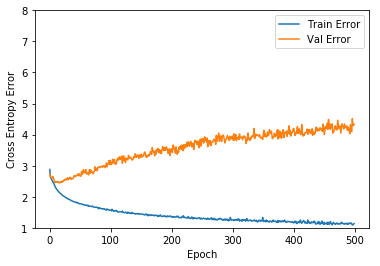

In [212]:
# Plot metrics
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Error')
    plt.plot(hist['epoch'], hist['categorical_crossentropy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_categorical_crossentropy'],
           label = 'Val Error')
    plt.ylim([1,8])
    plt.legend()
    plt.show()
    
plot_history(nn_history)

In [213]:
# See Training Accuracy
hist = pd.DataFrame(nn_history.history)
accuracy_vec = hist.pop("acc")
finalAcc = accuracy_vec[len(accuracy_vec) - 1]
print("Final accuracy: {}%".format(finalAcc*100))

Final accuracy: 58.67318511009216%


In [214]:
# Expects list
def accuracy(predictions, true_label):
    count = 0
    total = len(predictions)
    for i in range(total):
        if predictions[i] == true_label[i]:
            count += 1
    return float(count) / total

In [215]:
# Test accuracy:
y_prob = nn_model.predict(test)
y_classes = y_prob.argmax(axis=-1)
accuracy(y_classes, testy_integer_classes)

0.0499001996007984

In [ ]:
%%time
# Logistic Regression Model
df2 = pd.read_pickle("./data/pandas-pickle-small.pkl")
df2 = df2.sample(frac=1, random_state=2).reset_index(drop=True) # Shuffles data
# # print("This is our X: ", df2.iloc[:, ]
numTrain = 9000
numTest = 1000

X = df2.iloc[0:numTrain, :NUM_FEATURES]
X_array = X.values

y = df2.iloc[0:numTrain, NUM_FEATURES:]
y_array = y.values

y_array_rows = y_array.shape[0]

y_integer_classes = np.array([])
for i in range(y_array_rows):
    row = y_array[i]
    index = np.where(row==1)[0][0]
    y_integer_classes = np.append(y_integer_classes, int(index))

testX = df2.iloc[numTrain:numTrain+numTest, :NUM_FEATURES]
testX_array = testX.values
testY = df2.iloc[numTrain:numTrain+numTest, NUM_FEATURES:]
testY_array = testY.values

testy_array_rows = testY_array.shape[0]
testy_integer_classes = np.array([])
for i in range(testy_array_rows):
    row = testY_array[i]
    index = np.where(row==1)[0][0]
    testy_integer_classes = np.append(testy_integer_classes, int(index))

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
n_estimators = 10
print("Prediction results: \n")
predictions = OneVsRestClassifier(BaggingClassifier(LinearSVC(random_state=0, max_iter=1000), n_estimators = n_estimators)).fit(X_array, y_integer_classes).predict(testX_array)
print(predictions)
print("True results: \n")
print(testy_integer_classes)


# Expects list
def accuracy(predictions, true_label):
    count = 0
    total = len(predictions)
    for i in range(total):
        if predictions[i] == true_label[i]:
            count += 1
    return float(count) / total

pred_list = predictions.tolist()
testy_list = testy_integer_classes.tolist()
print("SVM accuracy: {}%".format(accuracy(pred_list, testy_list)*100))
        